<a href="https://colab.research.google.com/github/1am-Fida/skripsi/blob/main/Vallis_El_Nino.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Install

In [38]:
pip install dysts

In [39]:
pip install statsmodels

In [40]:
pip install nolds

In [41]:
pip install darts

In [42]:
import torch, numpy as np

# Kalau saya sukanya cek versi dan apakah PyTorch (atau tensorflow) sudah dapat mengakses GPU atau belum
print("Using Numpy and Pytorch versions = {}, {}".format(np.__version__, torch.__version__))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device, end=', ')
if device.type == 'cuda': #Additional Info when using cuda
    print(torch.cuda.get_device_name(0))
    print('Currently Memory Allocated, Cached =', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB, ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using Numpy and Pytorch versions = 1.22.4, 2.0.1+cu118
Using device: cpu, 

### Data

In [43]:
from dysts.datasets import load_dataset
import pandas as pd
import darts
import matplotlib.pyplot as plt
from darts.models import RandomForest,FFT,ARIMA,AutoARIMA,StatsForecastAutoARIMA,NaiveDrift,ExponentialSmoothing,Croston,StatsForecastAutoETS,StatsForecastAutoTheta,FourTheta,RegressionEnsembleModel,NBEATSModel
from darts.metrics import mape, smape, rmse
import warnings; warnings.simplefilter('ignore'); warnings.filterwarnings('ignore', module='darts'); warnings.filterwarnings('ignore', module='pandas')
import sys
from darts import metrics
from darts.utils.utils import TrendMode,ModelMode,SeasonalityMode
np.random.seed(1)

In [44]:
data = 'VallisElNino'
train_ = load_dataset(subsets="train", data_format="pandas", univariate=True, standardize=True).loc[data]
test_ = load_dataset(subsets="test", data_format="pandas", univariate=True, standardize=True).loc[data]

In [45]:
df = pd.concat([train_, test_], ignore_index=True) # , keys=["Train", "Test", "Validation"]
df.drop(['id'], axis=1, inplace=True)
df = df[['values']]#sol[['time', 'values_0']]


In [46]:
df.head()

,values
0,-0.557422
1,-0.515660
2,-0.479189
3,-0.448062
4,-0.422230


### exploratory data analys

In [47]:
(pd.concat([train_,test_],axis=0).reset_index()).describe()

,id,time,values
count,2000.0,2000.000000,2.000000e+03
mean,124.0,11.041658,1.207923e-16
std,0.0,6.382878,1.000250e+00
min,124.0,0.000000,-2.464222e+00
25%,124.0,5.520829,-6.640852e-01
50%,124.0,11.041658,2.381192e-02
75%,124.0,16.562487,7.334167e-01
max,124.0,22.083316,2.230959e+00


<Axes: >

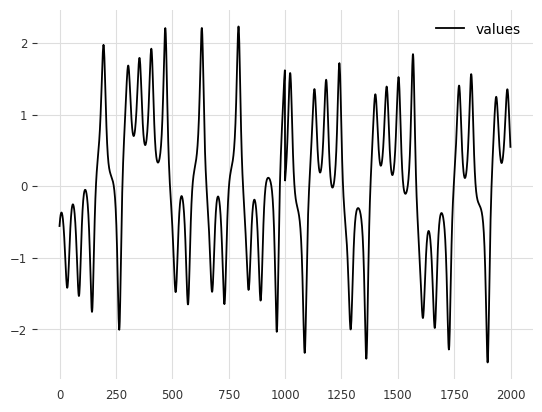

In [48]:
df.plot()

In [49]:
import statsmodels.api as sm

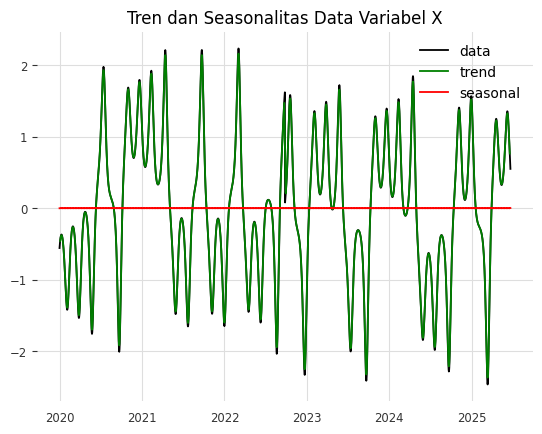

In [50]:
series_x = list(pd.concat([train_['values'], test_['values']], ignore_index=True))
date_rng = pd.date_range(start='1/1/2020', periods=2000)
series_x = pd.DataFrame(series_x, index=date_rng)
decomposition = sm.tsa.seasonal_decompose(series_x, model='additive')

plt.title('Tren dan Seasonalitas Data Variabel X')
plt.plot(series_x, label='data')
plt.plot(decomposition.trend, color='green', label='trend')
plt.plot(decomposition.seasonal, color='red', label='seasonal')
plt.legend(loc='upper right')
plt.show()

In [51]:
result = sm.tsa.adfuller(series_x)
# Menampilkan hasil uji ADF
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}: {value}')

ADF Statistic: -6.022379969577163
p-value: 1.483168368746184e-07
Critical Values:
1%: -3.4336419856688276
5%: -2.862994217611322
10%: -2.567544164035933


**nolds**

In [52]:
import numpy as np
import nolds
largest_lyap = nolds.lyap_r(train_['values'])

entro = nolds.sampen(train_['values'])

print("lyapunov",largest_lyap)
print("entrophy",entro)

lyapunov 0.009789828026205082
entrophy 0.23146564677511222


In [53]:
#min_params = df[['values']].min()
#max_params = df[['values']].max()

#df[['values']] = (df[['values']] - min_params) / (max_params- min_params)

**split data becoming data train and test**

In [54]:
def df2series(df, cols):
    for i, col in enumerate(df[cols].columns):
        if i==0:
            series = darts.TimeSeries.from_dataframe(df, time_col=None, value_cols=col)
        else:
            series = series.stack(darts.TimeSeries.from_dataframe(df, time_col=None, value_cols=col))
    return series

cols = ['values'] # Silahkan rename jadi x, y, z


all = df2series(df, cols)
train, test = all.split_after(0.975)
print('Data train',len(train), '\nData test',len(test))

Data train 1950 
Data test 50


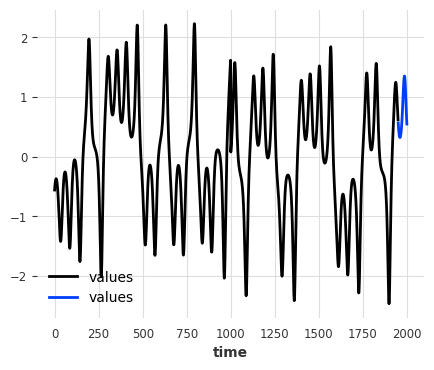

In [55]:
plt.figure(figsize=(5,4))
train['values'].plot()
test['values'].plot()

###RandomForest

In [ ]:
def RF(data, model, pVal=0.05, n_jobs=8, verbose_=False, metric_='smape'):

    parameters = {
        "lags": list(range(2, 13)), # list(range(2, 13)),
        "output_chunk_length" : [20, 30],#25#[10, 15, 20, 25]
        "n_estimators":[20,50], #25#10, 25, 50 list(range(10,110,10))
        "random_state":[0]
        }

    train, val = data.split_after(1-pVal)
    res = model.gridsearch(
        parameters=parameters,
        series=train,
        val_series=val,
        start=0.1,  # starting point in training set
        last_points_only=False,
        metric=getattr(metrics, metric_),
        reduction=np.mean,
        n_jobs=n_jobs,
        n_random_samples=None,# 0.99 % of full search space to evaluate
        verbose=verbose_,
    )
    return res

In [ ]:
model, bestparams, bestMetric_ = RF(train, RandomForest)
print("BestParameters", bestparams)
print("bestMetric_", bestMetric_)
# ===================== Training, Forecast & BackTest for Cross Validation=============================
print("GridSearch Finished,Training Best Model ... ", flush=True)
model.fit(train)
forecast_ = model.predict(len(test))
smape_ = darts.metrics.smape(test, forecast_)
rmse_ = darts.metrics.rmse(test, forecast_)
print("Pada data test RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

BestParameters {'lags': 4, 'output_chunk_length': 20, 'n_estimators': 20, 'random_state': 0}
bestMetric_ 70.37400463687064
GridSearch Finished,Training Best Model ... 
Pada data test RMSE=0.21918428502051487, sMAPE=16.44882515313604 


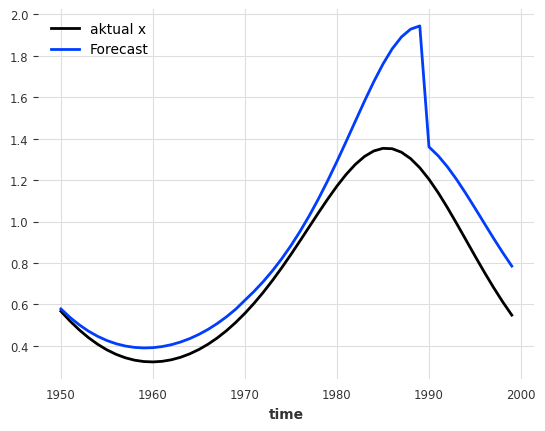

In [ ]:
test['values'].plot(label='aktual x')

forecast_['values'].plot(label='Forecast')
plt.show()

cross validation

In [ ]:
# ===================== Forecast & BackTest for Cross Validation=============================
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
model, bestparams, bestMetric_ = RF(train, RandomForest)

Starting Backtest (Expanding Window) Cross Validation ...


In [ ]:
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
backTest = model.historical_forecasts(all, start=.9, forecast_horizon=10)

print("Backtest Finished", flush=True)
# ===================== Evaluate =============================

Starting Backtest (Expanding Window) Cross Validation ...
Backtest Finished


In [ ]:
print(len(backTest))

192


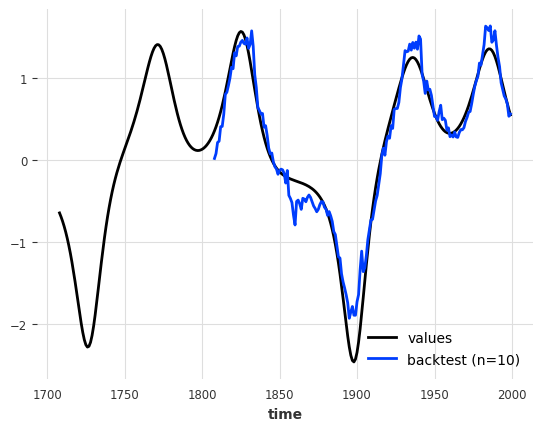

In [ ]:
all[-len(backTest)-100:].plot()
backTest.plot(label='backtest (n=10)')

In [ ]:
smape_ = darts.metrics.smape(all, backTest)
rmse_ = darts.metrics.rmse(all, backTest)
print("Hasil Cross Validasi RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

Hasil Cross Validasi RMSE=0.20896389799321796, sMAPE=26.433989794039466 


### AutoARIMA

In [ ]:
def AA(data, model, pVal=0.05, n_jobs=8, verbose_=False, metric_='smape'):

    parameters = {
        #'p':list(range(0,3)),
        #'d':range(0,3),
        #'q':range(0,3),
        #'start_p':[1,2,3],
        #'start_d':[1,2,3],
        #'max_p':[1,2,3],
        #'max_d':[1,2,3],
        #'max_q':[2,3],
        #"random_state":[0],
    }

    train, val = data.split_after(1-pVal)
    res = model.gridsearch(
        parameters=parameters,
        series=train,
        val_series=val,
        start=0.1,  # starting point in training set
        last_points_only=False,
        metric=getattr(metrics, metric_),
        reduction=np.mean,
        n_jobs=n_jobs,
        n_random_samples=None,# 0.99 % of full search space to evaluate
        verbose=verbose_,
    )
    return res

In [ ]:
model, bestparams, bestMetric = AA(train, AutoARIMA)
print("BestParameters", bestparams)
print("bestMetric_", bestMetric)
# ===================== Training, Forecast & BackTest for Cross Validation=============================
print("GridSearch Finished,Training Best Model ... ", flush=True)
model.fit(train)
forecast= model.predict(len(test))
smape_ = darts.metrics.smape(test, forecast)
rmse_ = darts.metrics.rmse(test, forecast)
print("Pada data test RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

BestParameters {}
bestMetric_ 164.20282615141494
GridSearch Finished,Training Best Model ... 
Pada data test RMSE=0.7675976305816569, sMAPE=128.11197544934237 


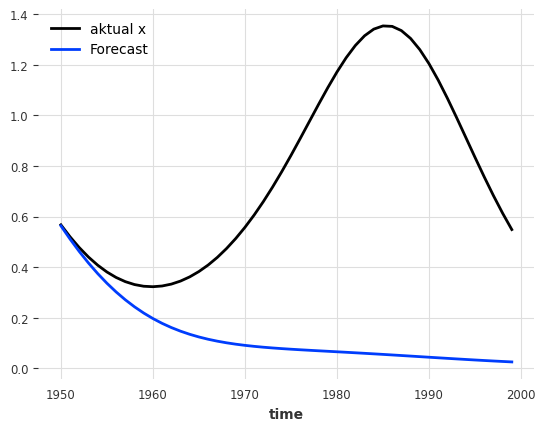

In [ ]:
test['values'].plot(label='aktual x')
forecast['values'].plot(label='Forecast')
plt.show()

**cross validation**

In [ ]:
# ===================== Forecast & BackTest for Cross Validation=============================
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
model, bestparams, bestMetric = AA(train, AutoARIMA)

Starting Backtest (Expanding Window) Cross Validation ...


In [ ]:
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
backTest = model.historical_forecasts(all, start=.9, forecast_horizon=10)

print("Backtest Finished", flush=True)
# ===================== Evaluate =============================

Starting Backtest (Expanding Window) Cross Validation ...
Backtest Finished


In [ ]:
print(len(backTest))

192


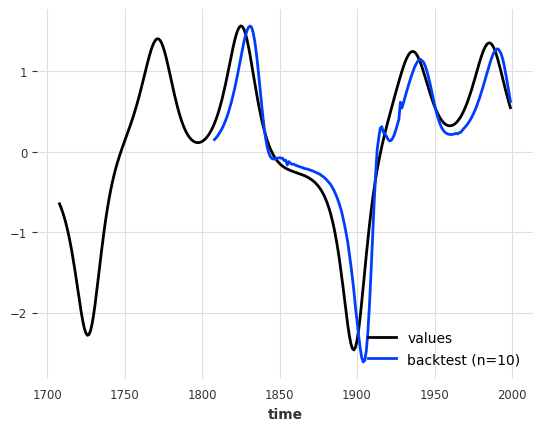

In [ ]:
all[-len(backTest)-100:].plot()
backTest.plot(label='backtest (n=10)')

In [ ]:
smape_ = darts.metrics.smape(all, backTest)
rmse_ = darts.metrics.rmse(all, backTest)
print("Hasil Cross Validasi RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

Hasil Cross Validasi RMSE=0.3922678822219114, sMAPE=48.8622142766154 


### StatForecastAUTOARIMA

In [ ]:
from darts.models import StatsForecastAutoARIMA

In [ ]:
def SFAA(data, model, pVal=0.05, n_jobs=8, verbose_=False, metric_='smape'):

    parameters = {

        #"random_state":[0],
    }

    train, val = data.split_after(1-pVal)
    res = model.gridsearch(
        parameters=parameters,
        series=train,
        val_series=val,
        start=0.1,  # starting point in training set
        last_points_only=False,
        metric=getattr(metrics, metric_),
        reduction=np.mean,
        n_jobs=n_jobs,
        n_random_samples=None,# 0.99 % of full search space to evaluate
        verbose=verbose_,
    )
    return res

In [ ]:
model, bestparams, bestMetric = SFAA(train, StatsForecastAutoARIMA)
print("BestParameters", bestparams)
print("bestMetric_", bestMetric)
# ===================== Training, Forecast & BackTest for Cross Validation=============================
print("GridSearch Finished,Training Best Model ... ", flush=True)
model.fit(train)
forecast= model.predict(len(test))
smape_ = darts.metrics.smape(test, forecast)
rmse_ = darts.metrics.rmse(test, forecast)
print("Pada data test RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

BestParameters {}
bestMetric_ 70.37400463687064
GridSearch Finished,Training Best Model ... 
Pada data test RMSE=0.7703106410704981, sMAPE=129.33818649503812 


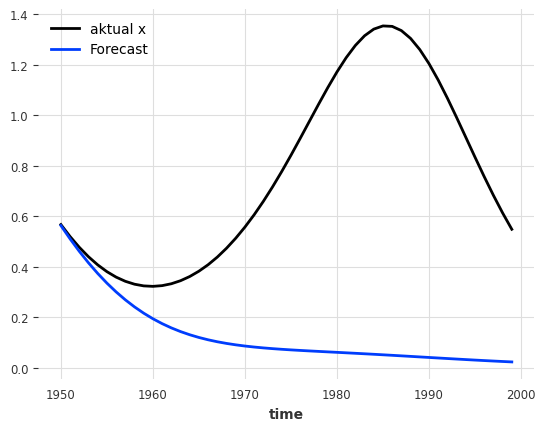

In [ ]:
test['values'].plot(label='aktual x')
forecast['values'].plot(label='Forecast')
plt.show()

**cross validation**

In [ ]:
# ===================== Forecast & BackTest for Cross Validation=============================
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
model, bestparams, bestMetric = SFAA(train, StatsForecastAutoARIMA)

Starting Backtest (Expanding Window) Cross Validation ...


In [ ]:
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
backTest = model.historical_forecasts(all, start=.9, forecast_horizon=10)

print("Backtest Finished", flush=True)
# ===================== Evaluate =============================

Starting Backtest (Expanding Window) Cross Validation ...
Backtest Finished


In [ ]:
print(len(backTest))

192


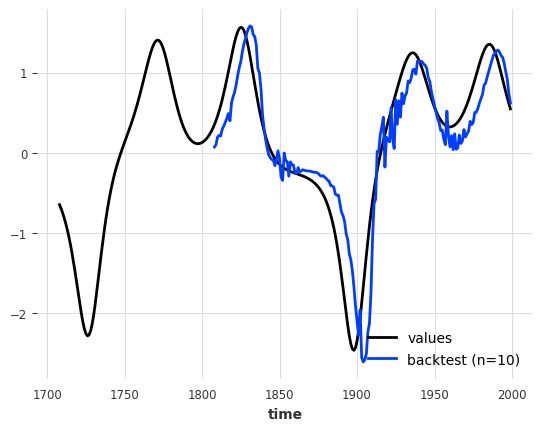

In [ ]:
all[-len(backTest)-100:].plot()
backTest.plot(label='backtest (n=10)')

In [ ]:
smape_ = darts.metrics.smape(all, backTest)
rmse_ = darts.metrics.rmse(all, backTest)
print("Hasil Cross Validasi RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

Hasil Cross Validasi RMSE=0.4168877068153145, sMAPE=56.680403044210436 


### ARIMA

In [19]:
from darts.models import ARIMA

In [255]:
def AR(data, model, pVal=0.05, n_jobs=8, verbose_=False, metric_='smape'):

    parameters = {
        'p':[15,18,20],#[0,1,2,3]=1,1,10/15 #[4,5],[0,1,2],[15,18,20]=(4,2,15)=64.31 #non=32. #
        'd':[1,2],#[0,1]
        'q':[15,18,20],#
        "random_state":[0],
    }

    train, val = data.split_after(1-pVal)
    res = model.gridsearch(
        parameters=parameters,
        series=train,
        val_series=val,
        start=0.1,  # starting point in training set
        last_points_only=False,
        metric=getattr(metrics, metric_),
        reduction=np.mean,
        n_jobs=n_jobs,
        n_random_samples=None,# 0.99 % of full search space to evaluate
        verbose=verbose_,
    )
    return res

In [256]:
model_ARIMA, bestparams, bestMetric = AR(train, ARIMA)
print("BestParameters", bestparams)
print("bestMetric_", bestMetric)
# ===================== Training, Forecast & BackTest for Cross Validation=============================
print("GridSearch Finished,Training Best Model ... ", flush=True)
model_ARIMA.fit(train)
forecast= model_ARIMA.predict(len(test))
smape_ = darts.metrics.smape(test, forecast)
rmse_ = darts.metrics.rmse(test, forecast)
print("Pada data test RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

BestParameters {'p': 20, 'd': 2, 'q': 20, 'random_state': 0}
bestMetric_ 117.90987611044797
GridSearch Finished,Training Best Model ... 
Pada data test RMSE=0.49044018806098333, sMAPE=49.9386683217582 


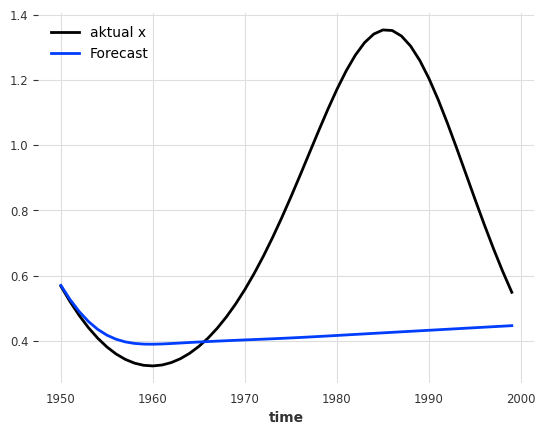

In [22]:
test['values'].plot(label='aktual x')
forecast['values'].plot(label='Forecast')
plt.show()

**cross validation**

In [23]:
# ===================== Forecast & BackTest for Cross Validation=============================
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
model_ARIMA, bestparams, bestMetric = AR(train, ARIMA)

Starting Backtest (Expanding Window) Cross Validation ...


In [24]:
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
backTest = model_ARIMA.historical_forecasts(all, start=.9, forecast_horizon=10)

print("Backtest Finished", flush=True)
# ===================== Evaluate =============================

Starting Backtest (Expanding Window) Cross Validation ...
Backtest Finished


In [25]:
print(len(backTest))

192


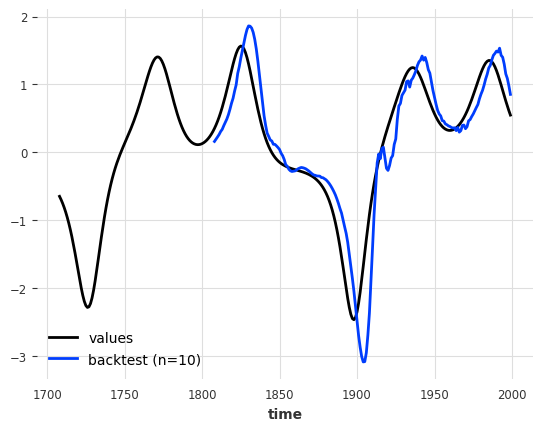

In [26]:
all[-len(backTest)-100:].plot()
backTest.plot(label='backtest (n=10)')

In [27]:
smape_ = darts.metrics.smape(all, backTest)
rmse_ = darts.metrics.rmse(all, backTest)
print("Hasil Cross Validasi RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

Hasil Cross Validasi RMSE=0.44114122673646167, sMAPE=48.834465044744505 


### FourTheta

In [56]:
def fort(data, model, pVal=0.05, n_jobs=8, verbose_=False, metric_='smape'):

    parameters = {
        "theta": list(range(0,2)),
        "seasonality_period" : [None],#True
        "season_mode" : [SeasonalityMode.ADDITIVE,SeasonalityMode.NONE],#SeasonalityMode.MULTIPLICATIVE,
        "model_mode" : [ModelMode.ADDITIVE],
        "trend_mode" : [TrendMode.EXPONENTIAL,TrendMode.LINEAR],
        'normalization' : [True,False],
        #"random_state":[0],
    }

    train, val = data.split_after(1-pVal)
    res = model.gridsearch(
        parameters=parameters,
        series=train,
        val_series=val,
        start=0.1,  # starting point in training set
        last_points_only=False,
        metric=getattr(metrics, metric_),
        reduction=np.mean,
        n_jobs=n_jobs,
        n_random_samples=None,# 0.99 % of full search space to evaluate
        verbose=verbose_,
    )
    return res

In [57]:
model, bestparams, bestMetric = fort(train, FourTheta)
print("BestParameters", bestparams)
print("bestMetric_", bestMetric)
# ===================== Training, Forecast & BackTest for Cross Validation=============================
print("GridSearch Finished,Training Best Model ... ", flush=True)
model.fit(train)
forecast= model.predict(len(test))
smape_ = darts.metrics.smape(test, forecast)
rmse_ = darts.metrics.rmse(test, forecast)
print("Pada data test RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

BestParameters {'theta': 1, 'seasonality_period': None, 'season_mode': <SeasonalityMode.NONE: None>, 'model_mode': <ModelMode.ADDITIVE: 'additive'>, 'trend_mode': <TrendMode.EXPONENTIAL: 'exponential'>, 'normalization': False}
bestMetric_ 138.7153223518575
GridSearch Finished,Training Best Model ... 


Pada data test RMSE=0.38600427826093064, sMAPE=43.696443620957275 


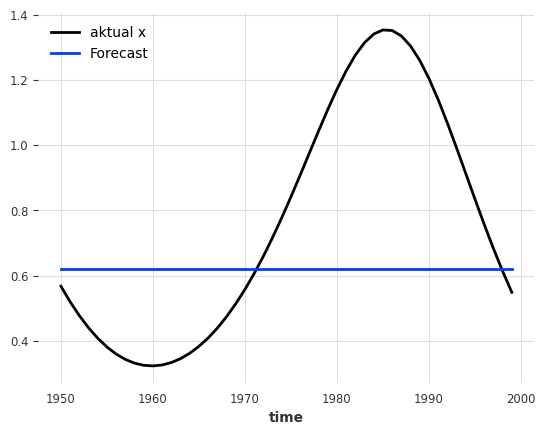

In [58]:
test['values'].plot(label='aktual x')
forecast['values'].plot(label='Forecast')
plt.show()

**cross validation**

In [59]:
# ===================== Forecast & BackTest for Cross Validation=============================
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
model, bestparams, bestMetric = fort(train, FourTheta)

Starting Backtest (Expanding Window) Cross Validation ...


In [60]:
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
backTest = model.historical_forecasts(all, start=.9, forecast_horizon=10)

print("Backtest Finished", flush=True)
# ===================== Evaluate =============================

Starting Backtest (Expanding Window) Cross Validation ...


Backtest Finished


In [61]:
print(len(backTest))

192


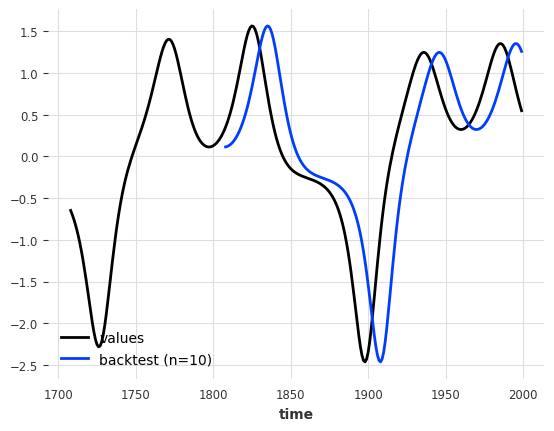

In [62]:
all[-len(backTest)-100:].plot()
backTest.plot(label='backtest (n=10)')

In [63]:
smape_ = darts.metrics.smape(all, backTest)
rmse_ = darts.metrics.rmse(all, backTest)
print("Hasil Cross Validasi RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

Hasil Cross Validasi RMSE=0.6882858947902676, sMAPE=81.0667253995562 


### FFT

In [64]:
from darts.models import FFT

In [65]:
def SFAETS(data, model, pVal=0.05, n_jobs=8, verbose_=False, metric_='smape'):

    parameters = {
        "nr_freqs_to_keep" : [1,2,3,4],#[1,2,3,4]=(2,p,3)=42.35
        #0,1,2,3(0,p,0=200),(2,p,3=42),(3,p,3=47),(5,p,5=48)
       #"required_matches":['month','day',None],
        "trend":['poly', 'exp', None],
        "trend_poly_degree" : [1,2,3,4],

        #"random_state":[0],
    }

    train, val = data.split_after(1-pVal)
    res = model.gridsearch(
        parameters=parameters,
        series=train,
        val_series=val,
        start=0.1,  # starting point in training set
        last_points_only=False,
        metric=getattr(metrics, metric_),
        reduction=np.mean,
        n_jobs=n_jobs,
        n_random_samples=None,# 0.99 % of full search space to evaluate
        verbose=verbose_,
    )
    return res

In [66]:
model, bestparams, bestMetric = SFAETS(train, FFT)
print("BestParameters", bestparams)
print("bestMetric_", bestMetric)
# ===================== Training, Forecast & BackTest for Cross Validation=============================
print("GridSearch Finished,Training Best Model ... ", flush=True)
model.fit(train)
forecast= model.predict(len(test))
smape_ = darts.metrics.smape(test, forecast)
rmse_ = darts.metrics.rmse(test, forecast)
print("Pada data test RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

BestParameters {'nr_freqs_to_keep': 2, 'trend': 'poly', 'trend_poly_degree': 3}
bestMetric_ 151.95046526697885
GridSearch Finished,Training Best Model ... 
Pada data test RMSE=0.3916043696703317, sMAPE=42.3596109371811 


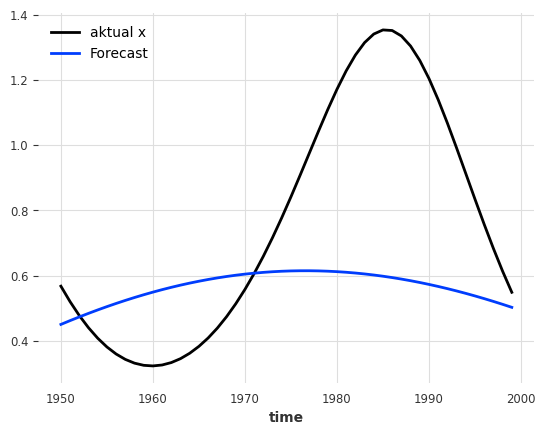

In [67]:
test['values'].plot(label='aktual x')
forecast['values'].plot(label='Forecast')
plt.show()

**cross validation**

In [68]:
# ===================== Forecast & BackTest for Cross Validation=============================
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
model, bestparams, bestMetric = SFAETS(train, FFT)

Starting Backtest (Expanding Window) Cross Validation ...


In [69]:
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
backTest = model.historical_forecasts(all, start=.9, forecast_horizon=10)

print("Backtest Finished", flush=True)
# ===================== Evaluate =============================

Starting Backtest (Expanding Window) Cross Validation ...
Backtest Finished


In [70]:
print(len(backTest))

192


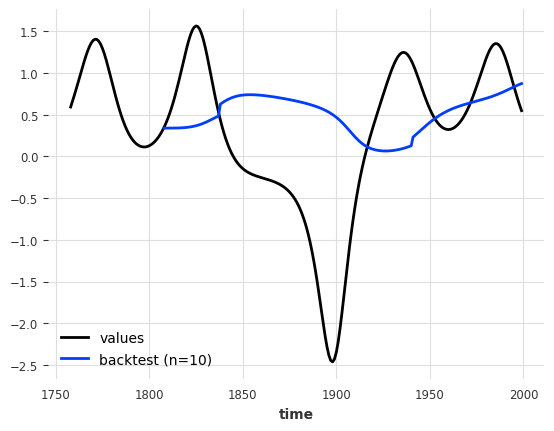

In [71]:
#all[-len(backTest)-100:].plot()
all[-len(backTest)-50:].plot()
backTest.plot(label='backtest (n=10)')

In [72]:
smape_ = darts.metrics.smape(all, backTest)
rmse_ = darts.metrics.rmse(all, backTest)
print("Hasil Cross Validasi RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

Hasil Cross Validasi RMSE=1.068372218979857, sMAPE=123.59046386324755 


### NaiveDrift (Naive Baseline)

In [73]:
from darts.models import NaiveDrift

In [74]:
def Drft(data, model, pVal=0.05, n_jobs=8, verbose_=False, metric_='smape'):

    parameters = {

        #"random_state":[0],
    }

    train, val = data.split_after(1-pVal)
    res = model.gridsearch(
        parameters=parameters,
        series=train,
        val_series=val,
        start=0.1,  # starting point in training set
        last_points_only=False,
        metric=getattr(metrics, metric_),
        reduction=np.mean,
        n_jobs=n_jobs,
        n_random_samples=None,# 0.99 % of full search space to evaluate
        verbose=verbose_,
    )
    return res

In [75]:
model, bestparams, bestMetric = Drft(train, NaiveDrift)
print("BestParameters", bestparams)
print("bestMetric_", bestMetric)
# ===================== Training, Forecast & BackTest for Cross Validation=============================
print("GridSearch Finished,Training Best Model ... ", flush=True)
model.fit(train)
forecast= model.predict(len(test))
smape_ = darts.metrics.smape(test, forecast)
rmse_ = darts.metrics.rmse(test, forecast)
print("Pada data test RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

BestParameters {}
bestMetric_ 139.98119304896744
GridSearch Finished,Training Best Model ... 
Pada data test RMSE=0.3750161386220283, sMAPE=42.70680340036289 


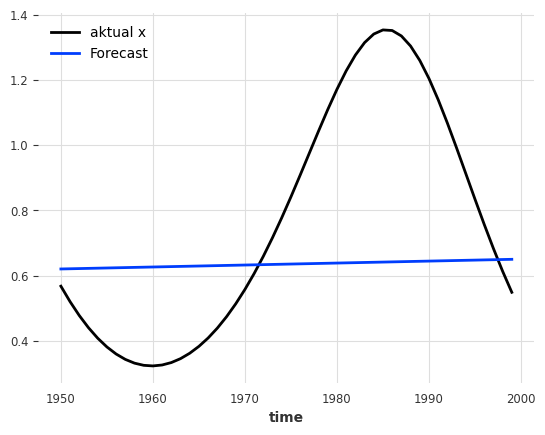

In [76]:
test['values'].plot(label='aktual x')
forecast['values'].plot(label='Forecast')
plt.show()

**cross validation**

In [77]:
# ===================== Forecast & BackTest for Cross Validation=============================
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
model, bestparams, bestMetric = Drft(train, NaiveDrift)

Starting Backtest (Expanding Window) Cross Validation ...


In [78]:
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
backTest = model.historical_forecasts(all, start=.9, forecast_horizon=10)

print("Backtest Finished", flush=True)
# ===================== Evaluate =============================

Starting Backtest (Expanding Window) Cross Validation ...
Backtest Finished


In [79]:
print(len(backTest))

192


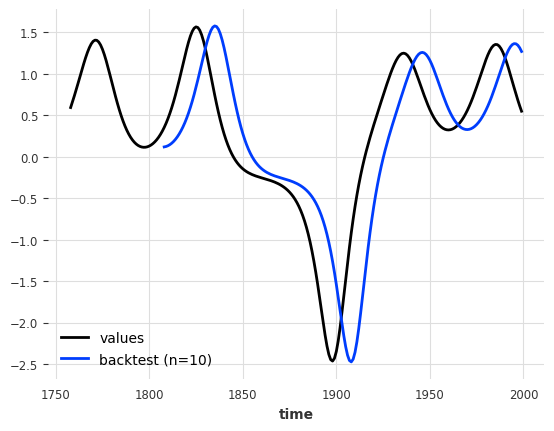

In [80]:
#all[-len(backTest)-100:].plot()
all[-len(backTest)-50:].plot()
backTest.plot(label='backtest (n=10)')

In [81]:
smape_ = darts.metrics.smape(all, backTest)
rmse_ = darts.metrics.rmse(all, backTest)
print("Hasil Cross Validasi RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

Hasil Cross Validasi RMSE=0.6898245773289754, sMAPE=81.05844344495857 


###exponential smoothing

In [82]:
from darts.models import ExponentialSmoothing
from darts.utils.utils import ModelMode, SeasonalityMode

def ES(data, model, pVal=0.05, n_jobs=8, verbose_=False, metric_='smape'):

    parameters = {
        "trend": [ModelMode.ADDITIVE,None],#ModelMode.MULTIPLICATIVE,
        "damped" : [False],#True
        "seasonal" : [SeasonalityMode.ADDITIVE,None],#SeasonalityMode.MULTIPLICATIVE,
        "random_state":[0],
    }

    train, val = data.split_after(1-pVal)
    res = model.gridsearch(
        parameters=parameters,
        series=train,
        val_series=val,
        start=0.1,  # starting point in training set
        last_points_only=False,
        metric=getattr(metrics, metric_),
        reduction=np.mean,
        n_jobs=n_jobs,
        n_random_samples=None,# 0.99 % of full search space to evaluate
        verbose=verbose_,
    )
    return res

In [83]:
model, bestparams, bestMetric = ES(train, ExponentialSmoothing)
print("BestParameters", bestparams)
print("bestMetric_", bestMetric)
# ===================== Training, Forecast & BackTest for Cross Validation=============================
print("GridSearch Finished,Training Best Model ... ", flush=True)
model.fit(train)
forecast = model.predict(len(test))
smape_ = darts.metrics.smape(test, forecast)
rmse_ = darts.metrics.rmse(test, forecast)
print("Pada data test RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

BestParameters {'trend': <ModelMode.ADDITIVE: 'additive'>, 'damped': False, 'seasonal': None, 'random_state': 0}
bestMetric_ 99.51968876226991
GridSearch Finished,Training Best Model ... 
Pada data test RMSE=1.9730658618765693, sMAPE=169.56108659975186 


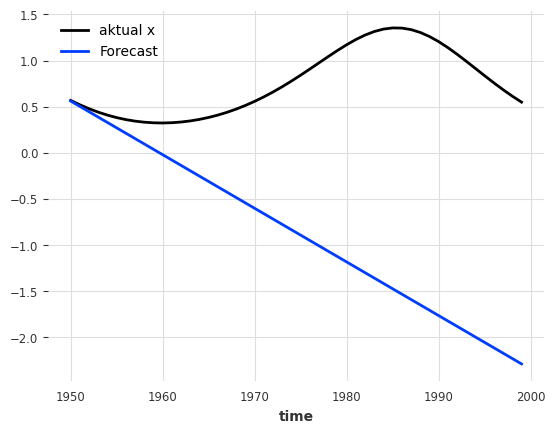

In [84]:
test['values'].plot(label='aktual x')

forecast['values'].plot(label='Forecast')
plt.show()

**cross validation**

In [85]:
# ===================== Forecast & BackTest for Cross Validation=============================
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
model, bestparams, bestMetric = ES(train, ExponentialSmoothing)

Starting Backtest (Expanding Window) Cross Validation ...


In [86]:
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
backTest = model.historical_forecasts(all, start=.9, forecast_horizon=10)

print("Backtest Finished", flush=True)
# ===================== Evaluate =============================

Starting Backtest (Expanding Window) Cross Validation ...
Backtest Finished


In [87]:
print(len(backTest))

192


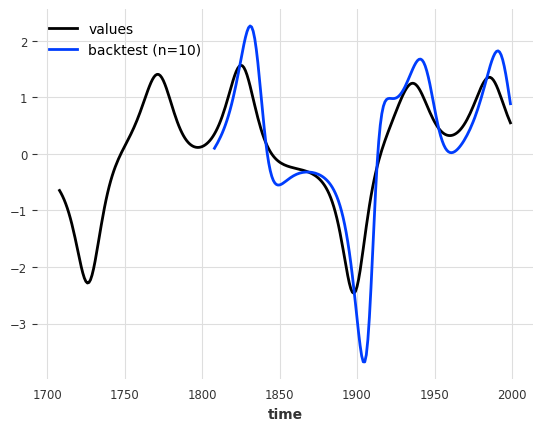

In [88]:
all[-len(backTest)-100:].plot()
backTest.plot(label='backtest (n=10)')

In [89]:
smape_ = darts.metrics.smape(all, backTest)
rmse_ = darts.metrics.rmse(all, backTest)
print("Hasil Cross Validasi RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

Hasil Cross Validasi RMSE=0.5779832669536861, sMAPE=56.308693731154115 


### StatsForecastAutoTheta

In [90]:
from darts.models import StatsForecastAutoTheta

In [91]:
def AT(data, model, pVal=0.05, n_jobs=8, verbose_=False, metric_='smape'):

    parameters = {
        'season_length':[0,3,12,60]

        #"random_state":[0],
    }

    train, val = data.split_after(1-pVal)
    res = model.gridsearch(
        parameters=parameters,
        series=train,
        val_series=val,
        start=0.1,  # starting point in training set
        last_points_only=False,
        metric=getattr(metrics, metric_),
        reduction=np.mean,
        n_jobs=n_jobs,
        n_random_samples=None,# 0.99 % of full search space to evaluate
        verbose=verbose_,
    )
    return res

In [92]:
model, bestparams, bestMetric = AT(train, StatsForecastAutoTheta)
print("BestParameters", bestparams)
print("bestMetric_", bestMetric)
# ===================== Training, Forecast & BackTest for Cross Validation=============================
print("GridSearch Finished,Training Best Model ... ", flush=True)
model.fit(train)
forecast= model.predict(len(test))
smape_ = darts.metrics.smape(test, forecast)
rmse_ = darts.metrics.rmse(test, forecast)
print("Pada data test RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

BestParameters {'season_length': 12}
bestMetric_ 137.64358870434575
GridSearch Finished,Training Best Model ... 
Pada data test RMSE=0.3844572339304628, sMAPE=43.72202096681382 


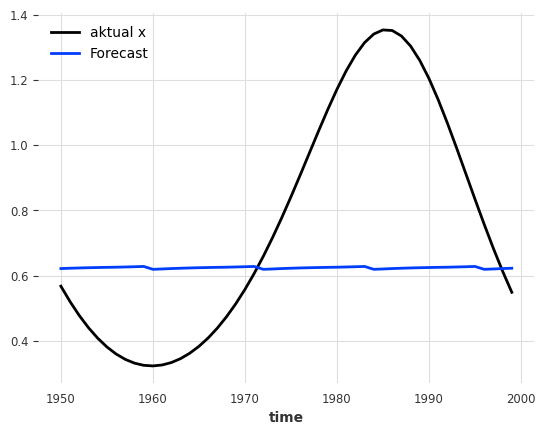

In [93]:
test['values'].plot(label='aktual x')
forecast['values'].plot(label='Forecast')
plt.show()

**cross validation**

In [94]:
# ===================== Forecast & BackTest for Cross Validation=============================
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
model, bestparams, bestMetric = AT(train, StatsForecastAutoTheta)

Starting Backtest (Expanding Window) Cross Validation ...


In [95]:
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
backTest = model.historical_forecasts(all, start=.9, forecast_horizon=10)

print("Backtest Finished", flush=True)
# ===================== Evaluate =============================

Starting Backtest (Expanding Window) Cross Validation ...
Backtest Finished


In [96]:
print(len(backTest))

192


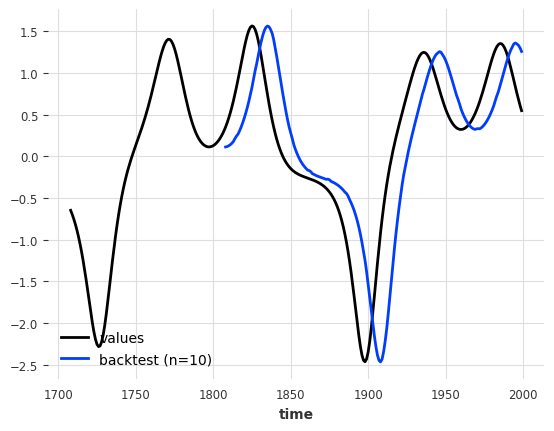

In [97]:
all[-len(backTest)-100:].plot()
backTest.plot(label='backtest (n=10)')

In [98]:
smape_ = darts.metrics.smape(all, backTest)
rmse_ = darts.metrics.rmse(all, backTest)
print("Hasil Cross Validasi RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

Hasil Cross Validasi RMSE=0.6888806835401668, sMAPE=81.10320168125371 


### StatForecast ETS

In [99]:
from darts.models import StatsForecastAutoETS

In [100]:
def ETS(data, model, pVal=0.05, n_jobs=8, verbose_=False, metric_='smape'):

    parameters = {
        'season_length':[4,8,15],#0,1,2,3,=136,
        'model':['ZZZ', 'AAN', 'ANN','AZZ','AAZ'],
                #['ZZZ','AAA', 'AAN', 'ANA', 'ANN', 'MAA', 'MAN', 'MNA', 'MNN']
                 #'ANN','ANA','ANM','AAN','AAA','AAM','AAdN','AAdA','AAdM',
                 #'MNN','MNA','MNM','MAN','MAA','MAM','MAdN','MAdA','MAdM']
                 #['A','M'],['N','A','Ad'],['N','A','M']],
        #'seasonal': ['add', 'additive', 'mul', 'multiplicative']
        #"random_state":[0],
    }

    train, val = data.split_after(1-pVal)
    res = model.gridsearch(
        parameters=parameters,
        series=train,
        val_series=val,
        start=0.1,  # starting point in training set
        last_points_only=False,
        metric=getattr(metrics, metric_),
        reduction=np.mean,
        n_jobs=n_jobs,
        n_random_samples=None,# 0.99 % of full search space to evaluate
        verbose=verbose_,
    )
    return res

In [101]:
model, bestparams, bestMetric = ETS(train, StatsForecastAutoETS)
print("BestParameters", bestparams)
print("bestMetric_", bestMetric)
# ===================== Training, Forecast & BackTest for Cross Validation=============================
print("GridSearch Finished,Training Best Model ... ", flush=True)
model.fit(train)
forecast= model.predict(len(test))
smape_ = darts.metrics.smape(test, forecast)
rmse_ = darts.metrics.rmse(test, forecast)
print("Pada data test RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

BestParameters {'season_length': 4, 'model': 'ZZZ'}
bestMetric_ 106.19022851120243
GridSearch Finished,Training Best Model ... 
Pada data test RMSE=0.8584660108214293, sMAPE=136.8207871441425 


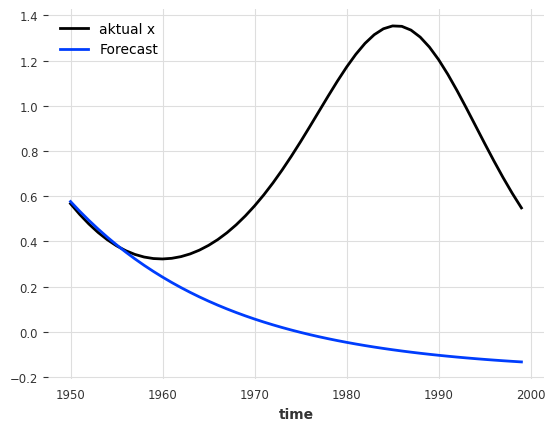

In [102]:
test['values'].plot(label='aktual x')
forecast['values'].plot(label='Forecast')
plt.show()

**cross validation**

In [103]:
# ===================== Forecast & BackTest for Cross Validation=============================
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
model, bestparams, bestMetric = ETS(train, StatsForecastAutoETS)

Starting Backtest (Expanding Window) Cross Validation ...


In [104]:
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
backTest = model.historical_forecasts(all, start=.9, forecast_horizon=10)


print("Backtest Finished", flush=True)
# ===================== Evaluate =============================

Starting Backtest (Expanding Window) Cross Validation ...
Backtest Finished


In [105]:
print(len(backTest))

192


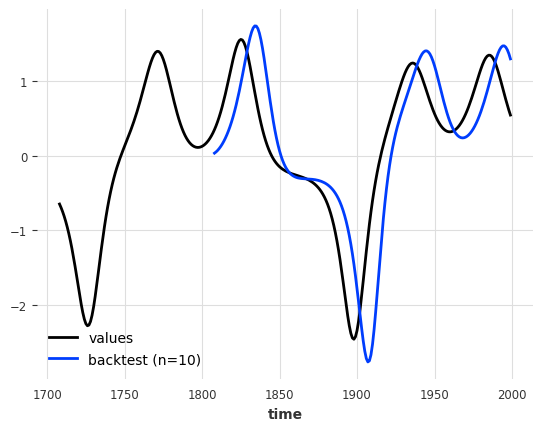

In [106]:
all[-len(backTest)-100:].plot()
backTest.plot(label='backtest (n=10)')

In [107]:
smape_ = darts.metrics.smape(all, backTest)
rmse_ = darts.metrics.rmse(all, backTest)
print("Hasil Cross Validasi RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

Hasil Cross Validasi RMSE=0.6607935040790175, sMAPE=69.76608479773996 


### StatsForecastAutoCES

In [108]:
from darts.models import StatsForecastAutoCES

In [109]:
def CES(data, model, pVal=0.05, n_jobs=8, verbose_=False, metric_='smape'):

    parameters = {
        #'season_length':[0,3,4,12],
        #'damped':[False]
        #"random_state":[0],
    }

    train, val = data.split_after(1-pVal)
    res = model.gridsearch(
        parameters=parameters,
        series=train,
        val_series=val,
        start=0.1,  # starting point in training set
        last_points_only=False,
        metric=getattr(metrics, metric_),
        reduction=np.mean,
        n_jobs=n_jobs,
        n_random_samples=None,# 0.99 % of full search space to evaluate
        verbose=verbose_,
    )
    return res

In [110]:
model, bestparams, bestMetric = CES(train, StatsForecastAutoCES)
print("BestParameters", bestparams)
print("bestMetric_", bestMetric)
# ===================== Training, Forecast & BackTest for Cross Validation=============================
print("GridSearch Finished,Training Best Model ... ", flush=True)
model.fit(train)
forecast= model.predict(len(test))
smape_ = darts.metrics.smape(test, forecast)
rmse_ = darts.metrics.rmse(test, forecast)
print("Pada data test RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

BestParameters {}
bestMetric_ 145.94470717837606
GridSearch Finished,Training Best Model ... 
Pada data test RMSE=0.4551085830386174, sMAPE=52.43787211922246 


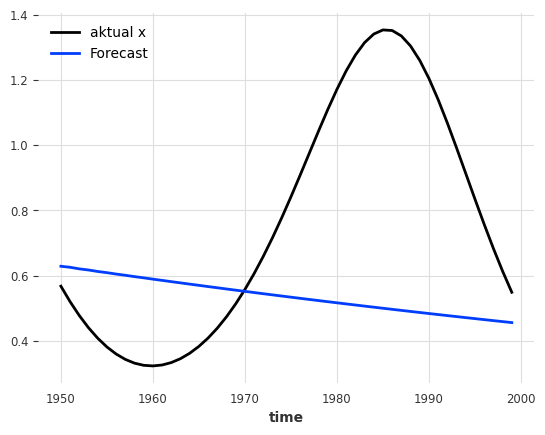

In [111]:
test['values'].plot(label='aktual x')
forecast['values'].plot(label='Forecast')
plt.show()

**cross validation**

In [112]:
# ===================== Forecast & BackTest for Cross Validation=============================
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
model, bestparams, bestMetric = CES(train, StatsForecastAutoCES)

Starting Backtest (Expanding Window) Cross Validation ...


In [113]:
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
backTest = model.historical_forecasts(all, start=.9, forecast_horizon=10)


print("Backtest Finished", flush=True)
# ===================== Evaluate =============================

Starting Backtest (Expanding Window) Cross Validation ...
Backtest Finished


In [114]:
print(len(backTest))

192


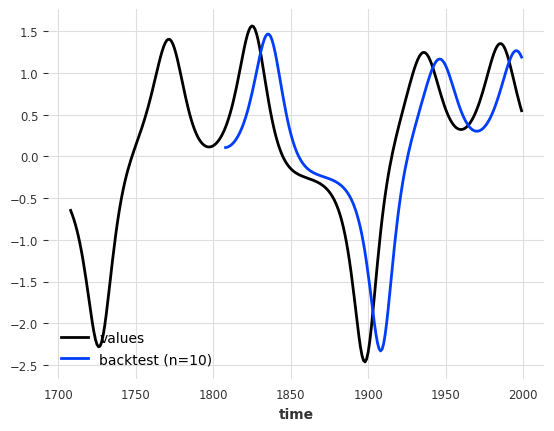

In [115]:
all[-len(backTest)-100:].plot()
backTest.plot(label='backtest (n=10)')

In [116]:
smape_ = darts.metrics.smape(all, backTest)
rmse_ = darts.metrics.rmse(all, backTest)
print("Hasil Cross Validasi RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

Hasil Cross Validasi RMSE=0.6869109564979858, sMAPE=84.10943160989976 


### Croston

In [117]:
from darts.models import Croston

In [118]:
def Cr(data, model, pVal=0.05, n_jobs=8, verbose_=False, metric_='smape'):

    parameters = {
        "version" : ['classic','optimized','sba','tsb'],
       "alpha_d":[0.0,0.01,0.05],
        "alpha_p":[0.0,0.01,0.05]
        #"random_state":[0],
    }

    train, val = data.split_after(1-pVal)
    res = model.gridsearch(
        parameters=parameters,
        series=train,
        val_series=val,
        start=0.1,  # starting point in training set
        last_points_only=False,
        metric=getattr(metrics, metric_),
        reduction=np.mean,
        n_jobs=n_jobs,
        n_random_samples=None,# 0.99 % of full search space to evaluate
        verbose=verbose_,
    )
    return res

In [119]:
model, bestparams, bestMetric = Cr(train, Croston)
print("BestParameters", bestparams)
print("bestMetric_", bestMetric)
# ===================== Training, Forecast & BackTest for Cross Validation=============================
print("GridSearch Finished,Training Best Model ... ", flush=True)
model.fit(train)
forecast= model.predict(len(test))
smape_ = darts.metrics.smape(test, forecast)
rmse_ = darts.metrics.rmse(test, forecast)
print("Pada data test RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

BestParameters {'version': 'tsb', 'alpha_d': 0.01, 'alpha_p': 0.0}
bestMetric_ 145.241805958405
GridSearch Finished,Training Best Model ... 
Pada data test RMSE=0.3602739930153791, sMAPE=44.17781159853785 


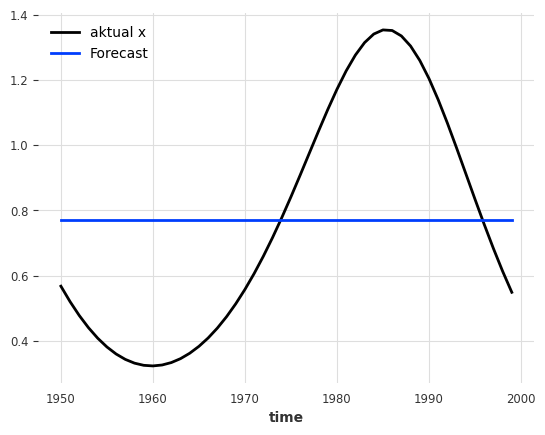

In [120]:
test['values'].plot(label='aktual x')
forecast['values'].plot(label='Forecast')
plt.show()

**cross validation**

In [121]:
# ===================== Forecast & BackTest for Cross Validation=============================
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
model, bestparams, bestMetric = Cr(train, Croston)

Starting Backtest (Expanding Window) Cross Validation ...


In [122]:
print("Starting Backtest (Expanding Window) Cross Validation ...", flush=True)
backTest = model.historical_forecasts(all, start=.9, forecast_horizon=10)

print("Backtest Finished", flush=True)
# ===================== Evaluate =============================

Starting Backtest (Expanding Window) Cross Validation ...
Backtest Finished


In [123]:
print(len(backTest))

192


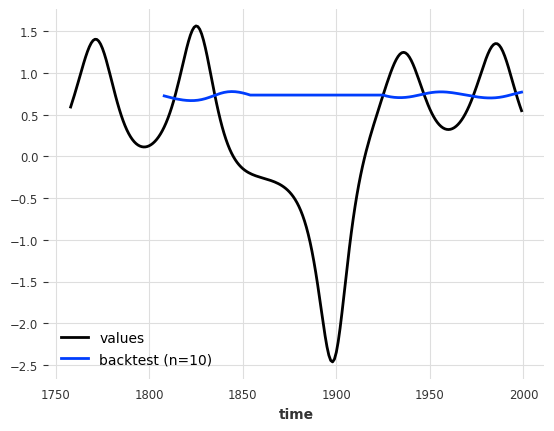

In [124]:
#all[-len(backTest)-100:].plot()
all[-len(backTest)-50:].plot()
backTest.plot(label='backtest (n=10)')

In [125]:
smape_ = darts.metrics.smape(all, backTest)
rmse_ = darts.metrics.rmse(all, backTest)
print("Hasil Cross Validasi RMSE={}, sMAPE={} ".format(rmse_, smape_), flush=True)

Hasil Cross Validasi RMSE=1.1018419059055107, sMAPE=105.42029988702879 


### Regresi Ensemble

#### code

In [126]:
from darts.metrics import smape, mape, mase, mae, mse, ope, r2_score, rmse, rmsle
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.dataprocessing.transformers.boxcox import BoxCox
import time

In [127]:
# compute accuracy metrics and processing time

def accuracy_metrics(act, forecast, resid):#, t_star
    sr = resid.pd_series()
    sa = act.pd_series()
    n_act = len(act)
    res_mape = mape(act, forecast)
    res_smape = smape(act, forecast)
    res_mae = mae(act, forecast)
    res_r2 = r2_score(act, forecast)
    res_rmse = rmse(act, forecast)
    res_rmsle = rmsle(act, forecast)
    res_pe = sr / sa
    res_rmspe = np.sqrt(np.sum(res_pe**2) / n_act)    # root mean square percentage error

    #res_time = time.perf_counter() - t_start

    res_mean = np.mean(sr)
    res_std = np.std(sr)                               # std error of the model = std deviation of the noise
    res_se = res_std / np.sqrt(n_act)                  # std error in estimating the mean
    res_sefc = np.sqrt(res_std + res_se**2)            # std error of the forecast

    res_accuracy = {"SMAPE" : res_smape,"MAPE":res_mape,"RMSE":res_rmse, "-R squared":-res_r2,
        "se": res_sefc} #, "time":res_time
    return res_accuracy

In [128]:
## fit the chosen forecaster model and compute predictions

def eval_model(model):
    #t_start =  time.perf_counter()
    strmodel = str(model)[:30]
    print("beginning: " + strmodel)


    # fit the model and compute predictions
    n_val = len(test)
    res = model.fit(train)
    forecast = model.predict(n_val)


    # for naive forecast, concatenate seasonal fc with drift fc
    ##if model == m_stat:
    ##    if is_seasonal:
    ##        fc_drift = forecast
      ##      modelS = NaiveSeasonal(K=mseas)
       ##     modelS.fit(train)
         #### forecast = fc_drift + fc_seas - train.last_value()


    resid = forecast - test
    res_accuracy = accuracy_metrics(test, forecast, resid)#, t_start


    results = [forecast, res_accuracy]

    print("completed: " + strmodel + ":" + str(res_accuracy["time"]) + " sec")
    return results

#### FFT & AutoARIMA

In [129]:
models_=[
        #StatsForecastAutoARIMA(),
        FFT( nr_freqs_to_keep = 2, trend= 'poly', trend_poly_degree=3),
        #ARIMA(p = 3, d= 1, q=5,random_state=0),
        AutoARIMA(),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [130]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    FFT( nr_freqs_to_keep = 2, trend= 'poly', trend_poly_degree=3),
                                    #StatsForecastAutoARIMA(),
                                    AutoARIMA(),
                                    #ARIMA(p = 3, d= 1, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


Ensemble of all 2 forecasters:


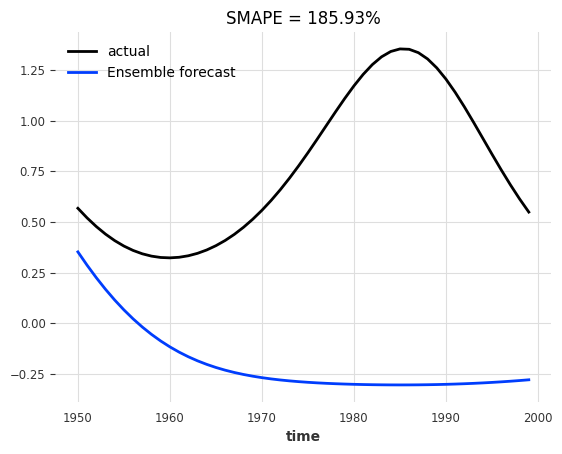

In [131]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### FFT & ARIMA

In [246]:
from darts.models import FFT
models_=[
        #StatsForecastAutoARIMA(),
        FFT( nr_freqs_to_keep = 2, trend= 'poly', trend_poly_degree=3),
        ARIMA(p = 20, d=2, q=20,random_state=0),
        #AutoARIMA(),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [247]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    FFT( nr_freqs_to_keep = 2, trend= 'poly', trend_poly_degree=3),
                                    #StatsForecastAutoARIMA(),
                                    #AutoARIMA(),
                                    ARIMA(p = 20, d=2, q=20,random_state=0)#(p = 4, d=2, q=15,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


Ensemble of all 2 forecasters:


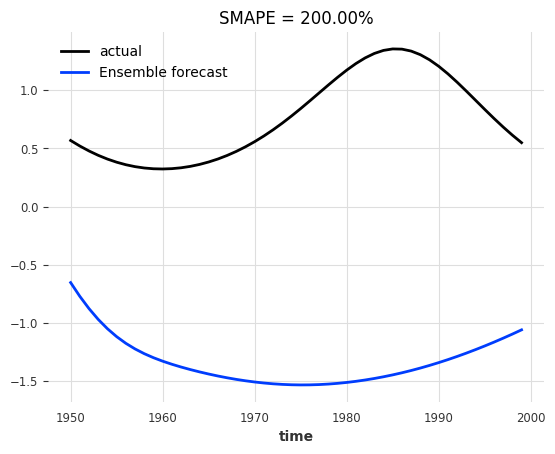

In [248]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### FFT & StatsForecastAutoARIMA


In [135]:
models_=[
        StatsForecastAutoARIMA(),
        FFT( nr_freqs_to_keep = 2, trend= 'poly', trend_poly_degree=3),
        #ARIMA(p = 3, d= 1, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [136]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    FFT( nr_freqs_to_keep = 2, trend= 'poly', trend_poly_degree=3),
                                    StatsForecastAutoARIMA(),
                                    #ARIMA(p = 3, d= 1, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


Ensemble of all 2 forecasters:


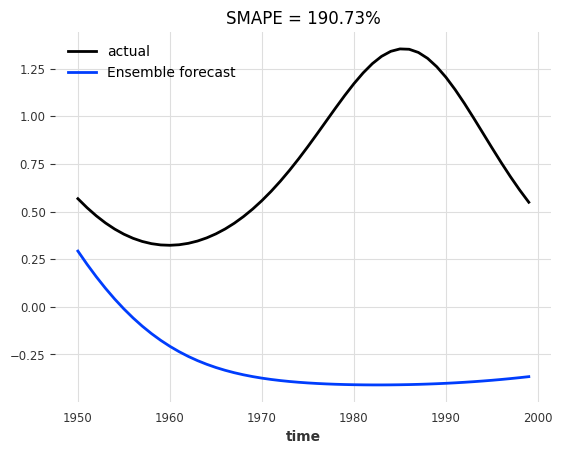

In [137]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### FFT & NaiveDrift

In [249]:
from darts.models import NaiveDrift,FFT

In [250]:
models_=[
        #StatsForecastAutoARIMA(),
        FFT( nr_freqs_to_keep = 2, trend= 'poly', trend_poly_degree=3),
        NaiveDrift()
        #ARIMA(p = 3, d= 1, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [251]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    FFT( nr_freqs_to_keep = 2, trend= 'poly', trend_poly_degree=3),
                                    NaiveDrift()
                                    #StatsForecastAutoARIMA(),
                                    #ARIMA(p = 3, d= 1, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


Ensemble of all 2 forecasters:


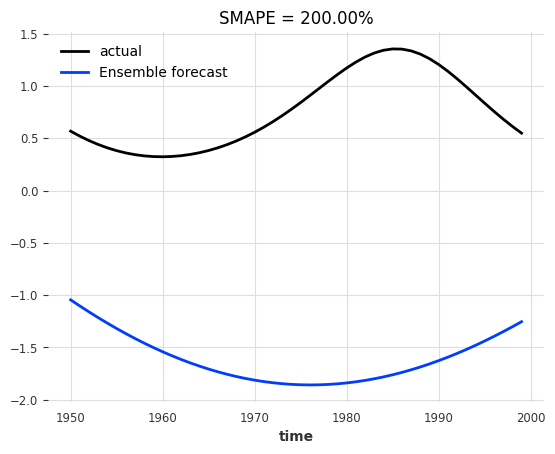

In [252]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### FFT & Expon

In [142]:
from darts.models import NaiveDrift,FFT

In [143]:
models_=[
        #StatsForecastAutoARIMA(),
        FFT( nr_freqs_to_keep = 2, trend= 'poly', trend_poly_degree=3),
        #NaiveDrift()
        #ARIMA(p = 3, d= 1, q=5,random_state=0),
        ExponentialSmoothing(trend=None, damped=False, seasonal=SeasonalityMode.ADDITIVE, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [144]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    FFT( nr_freqs_to_keep = 2, trend= 'poly', trend_poly_degree=3),
                                    #NaiveDrift()
                                    #StatsForecastAutoARIMA(),
                                    #ARIMA(p = 3, d= 1, q=5,random_state=0),
                                    ExponentialSmoothing(trend=None, damped=False, seasonal=SeasonalityMode.ADDITIVE, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


Ensemble of all 2 forecasters:


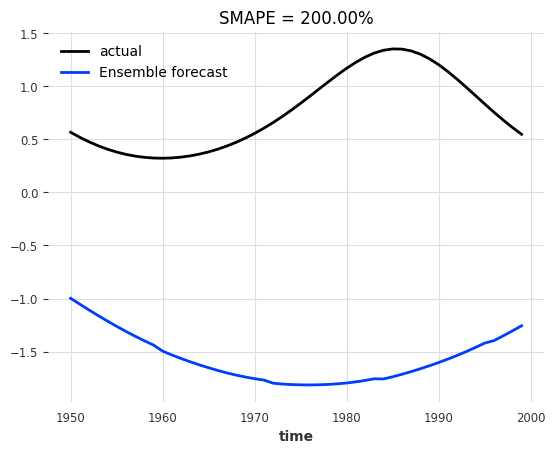

In [145]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### FFT & Croston

In [146]:
from darts.models import NaiveDrift,FFT,Croston

In [147]:
models_=[
        #StatsForecastAutoARIMA(),
        FFT( nr_freqs_to_keep = 2, trend= 'poly', trend_poly_degree=3),
        #NaiveDrift()
        Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
        #ARIMA(p = 3, d= 1, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [148]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    FFT( nr_freqs_to_keep = 2, trend= 'poly', trend_poly_degree=3),
                                    #NaiveDrift(),
                                    Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
                                    #StatsForecastAutoARIMA(),
                                    #ARIMA(p = 3, d= 1, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


Ensemble of all 2 forecasters:


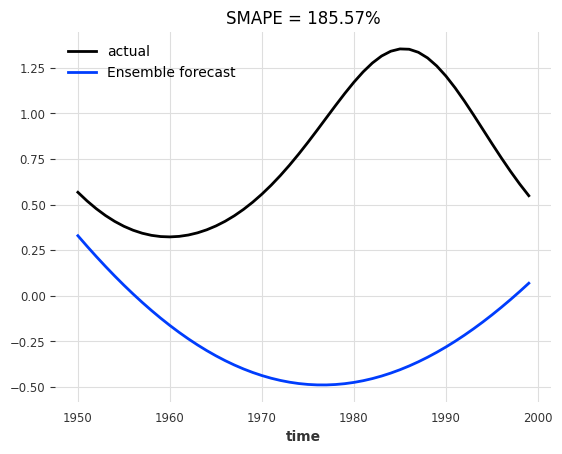

In [149]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### FFT & SF AutoTheta

In [150]:
from darts.models import NaiveDrift,FFT,Croston,StatsForecastAutoTheta

In [151]:
models_=[
        #StatsForecastAutoARIMA(),
        FFT( nr_freqs_to_keep = 2, trend= 'poly', trend_poly_degree=3),
        #NaiveDrift()
        StatsForecastAutoTheta(season_length=12),
        #Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
        #ARIMA(p = 3, d= 1, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12,output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [152]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    FFT( nr_freqs_to_keep = 2, trend= 'poly', trend_poly_degree=3),
                                    StatsForecastAutoTheta(season_length=12)
                                    #NaiveDrift(),
                                    #Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
                                    #StatsForecastAutoARIMA(),
                                    #ARIMA(p = 3, d= 1, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


Ensemble of all 2 forecasters:


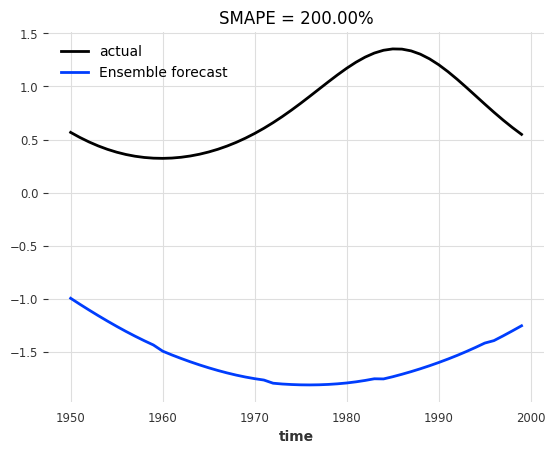

In [153]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### FFT & SF AutoETS

In [154]:
from darts.models import NaiveDrift,FFT,Croston,StatsForecastAutoETS

In [155]:
models_=[
        #StatsForecastAutoARIMA(),
        FFT( nr_freqs_to_keep = 2, trend= 'poly', trend_poly_degree=3),
        #NaiveDrift()
        StatsForecastAutoETS(season_length=4,model='AAZ'),
        #StatsForecastAutoTheta(),
        #Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
        #ARIMA(p = 3, d= 1, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [156]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    FFT( nr_freqs_to_keep = 2, trend= 'poly', trend_poly_degree=3),
                                    StatsForecastAutoETS(season_length=4,model='AAZ'),
                                    #StatsForecastAutoTheta()
                                    #NaiveDrift(),
                                    #Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
                                    #StatsForecastAutoARIMA(),
                                    #ARIMA(p = 3, d= 1, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


Ensemble of all 2 forecasters:


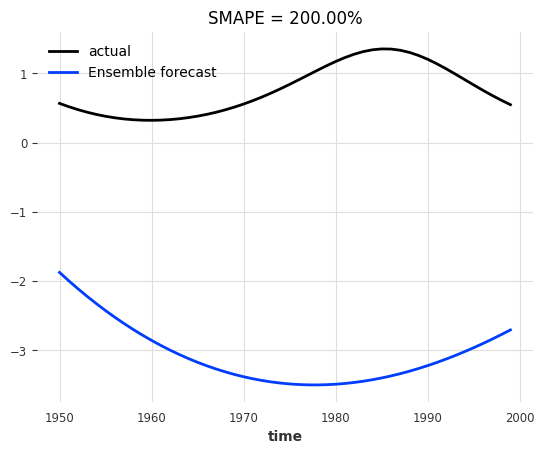

In [157]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### FFT &FourTheta

In [158]:
models_=[
        #StatsForecastAutoARIMA(),
        FFT( nr_freqs_to_keep = 2, trend= 'poly', trend_poly_degree=3),
        #ARIMA(p = 3, d= 1, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True),
        FourTheta(theta=1,seasonality_period=None,season_mode=SeasonalityMode.ADDITIVE,model_mode=ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL,normalization=False),

  ]

In [159]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    FFT( nr_freqs_to_keep = 2, trend= 'poly', trend_poly_degree=3),
                                    #StatsForecastAutoARIMA(),
                                    #ARIMA(p = 3, d= 1, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    FourTheta(theta=1,seasonality_period=None,season_mode=SeasonalityMode.ADDITIVE,model_mode=ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL,normalization=False)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


Ensemble of all 2 forecasters:


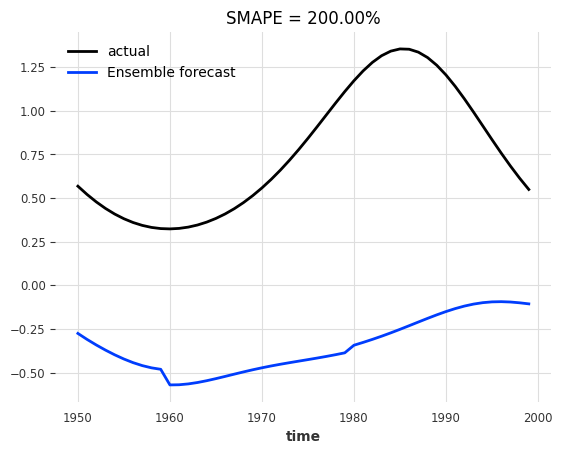

In [160]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### AutoARIMA & ARIMA

In [161]:
models_=[
        AutoARIMA(),
        ARIMA(p = 20, d=2, q=20,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [162]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    AutoARIMA(),
                                    ARIMA(p = 20, d=2, q=20,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


Ensemble of all 2 forecasters:


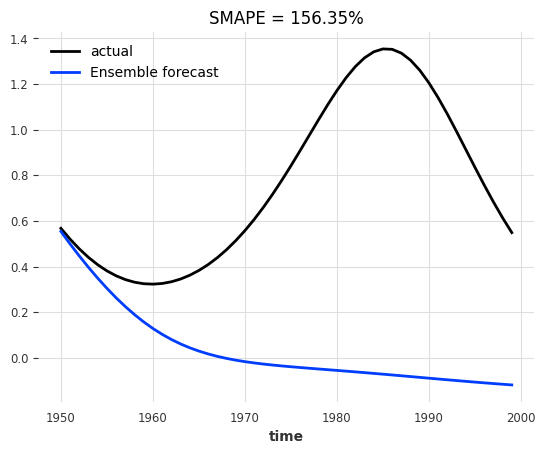

In [163]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### AutoARIMA & SF AutoARIMA

In [164]:
from darts.models import StatsForecastAutoARIMA

In [165]:
models_=[
        AutoARIMA(),
        StatsForecastAutoARIMA(),
        #ARIMA(p = 3, d=0, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [166]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    AutoARIMA(),
                                    StatsForecastAutoARIMA(),
                                    #ARIMA(p = 3, d= 0, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


Ensemble of all 2 forecasters:


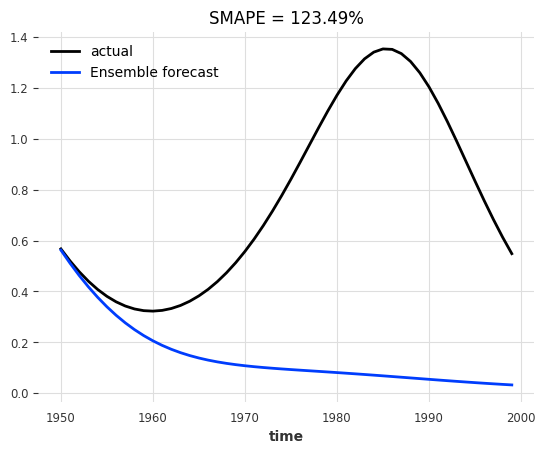

In [167]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### AutoARIMA & NaiveDrift

In [168]:
from darts.models import NaiveDrift

In [169]:
models_=[
        AutoARIMA(),
        NaiveDrift(),
        #ARIMA(p = 3, d=0, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [170]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    AutoARIMA(),
                                    NaiveDrift(),
                                    #ARIMA(p = 3, d= 0, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


Ensemble of all 2 forecasters:


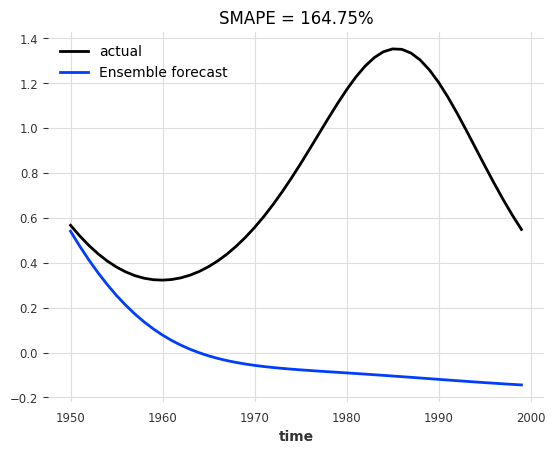

In [171]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### Auto ARIMA & Expon

In [172]:
models_=[
        AutoARIMA(),
        #ARIMA(p = 3, d= 1, q=5,random_state=0),
        ExponentialSmoothing(trend=None, damped=False, seasonal=SeasonalityMode.ADDITIVE, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [173]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    AutoARIMA(),
                                    #ARIMA(p = 3, d= 1, q=5,random_state=0),
                                    ExponentialSmoothing(trend=None, damped=False, seasonal=SeasonalityMode.ADDITIVE, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


Ensemble of all 2 forecasters:


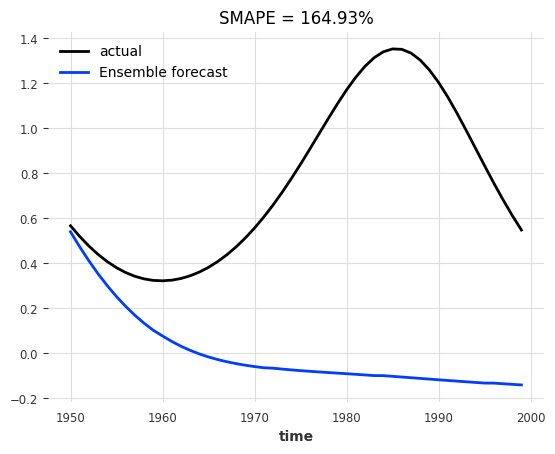

In [174]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### AutoARIMA & Croston

In [175]:
from darts.models import Croston

In [176]:
models_=[
        AutoARIMA(),
        Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
        #ARIMA(p = 3, d=0, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [177]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    AutoARIMA(),
                                    Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
                                    #ARIMA(p = 3, d= 0, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


Ensemble of all 2 forecasters:


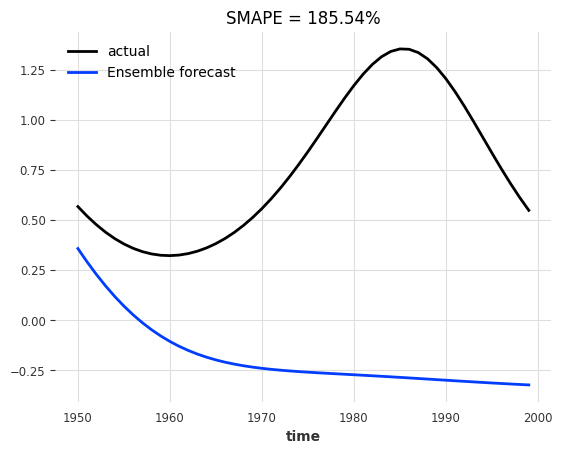

In [178]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### AutoARIMA & SF AutoTheta

In [179]:
from darts.models import NaiveDrift,FFT,Croston,StatsForecastAutoTheta

In [180]:
models_=[
        #StatsForecastAutoARIMA(),
        #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
        AutoARIMA(),
        #NaiveDrift()
        StatsForecastAutoTheta(season_length=12),
        #Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
        #ARIMA(p = 3, d= 1, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [181]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
                                    AutoARIMA(),
                                    StatsForecastAutoTheta(season_length=12),
                                    #NaiveDrift(),
                                    #Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
                                    #StatsForecastAutoARIMA(),
                                    #ARIMA(p = 3, d= 1, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


Ensemble of all 2 forecasters:


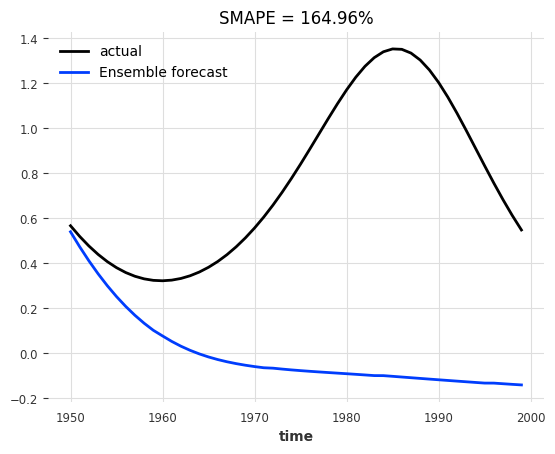

In [182]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### AutoARIMA & SF Auto ETS

In [183]:
from darts.models import StatsForecastAutoETS

In [184]:
models_=[
        AutoARIMA(),
        StatsForecastAutoETS(season_length=4,model='AAZ'),
        #Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
        #ARIMA(p = 3, d=0, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [185]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    AutoARIMA(),
                                    StatsForecastAutoETS(season_length=4,model='AAZ'),
                                    #Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
                                    #ARIMA(p = 3, d= 0, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


Ensemble of all 2 forecasters:


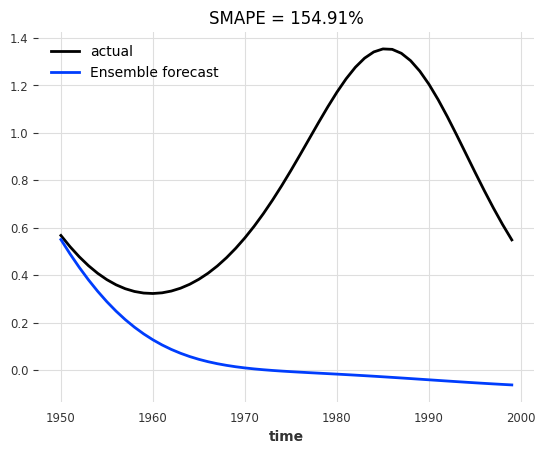

In [186]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### AutoARIMA dan FourTheta

In [187]:
models=[
        #StatsForecastAutoARIMA(),
        FourTheta(theta=1,seasonality_period=None,season_mode=SeasonalityMode.ADDITIVE,model_mode=ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL,normalization=False),
        AutoARIMA()
        ]

In [188]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #StatsForecastAutoARIMA(),
                                    FourTheta(theta=1,seasonality_period=None,season_mode=SeasonalityMode.ADDITIVE,model_mode=ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL,normalization=False),
                                    AutoARIMA(),

                                    ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


Ensemble of all 2 forecasters:


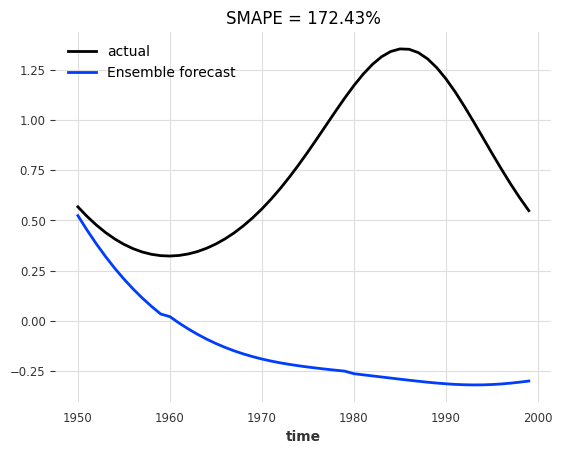

In [189]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = [#"SFAutoARIMA",
             "4Theta",'AutoARIMA' "avg", "Ensemble"]
models2 = models

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### ARIMA & StatsForecastAutoARIMA


In [190]:
models_=[
        StatsForecastAutoARIMA(),
        #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0)
        ARIMA(p = 20, d=2, q=20,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [191]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
                                    StatsForecastAutoARIMA(),
                                    ARIMA(p = 20, d=2, q=20,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


Ensemble of all 2 forecasters:


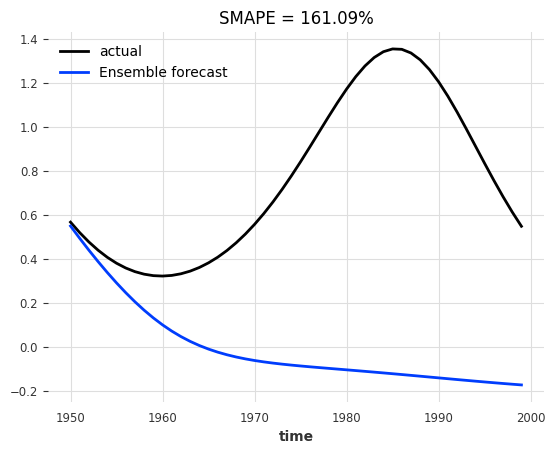

In [192]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### ARIMA & NaiveDrift

In [193]:
from darts.models import NaiveDrift,FFT

In [194]:
models_=[
        #StatsForecastAutoARIMA(),
        #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
        NaiveDrift(),
        ARIMA(p = 20, d=2, q=20,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [195]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
                                    NaiveDrift(),
                                    #StatsForecastAutoARIMA(),
                                    ARIMA(p = 20, d=2, q=20,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


Ensemble of all 2 forecasters:


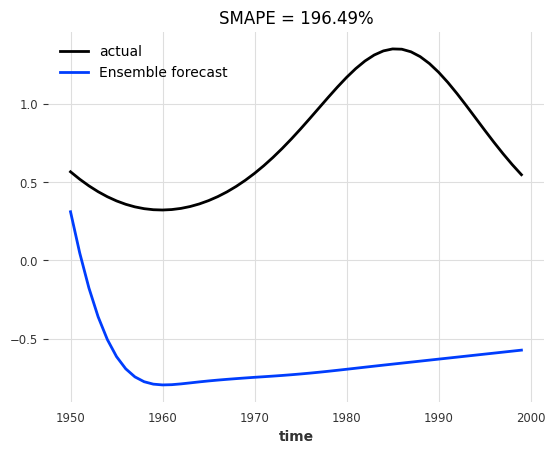

In [196]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### ARIMA & Expon

In [197]:
from darts.models import NaiveDrift,FFT

In [198]:
models_=[
        #StatsForecastAutoARIMA(),
        #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
        #NaiveDrift()
        ARIMA(p = 20, d=2, q=20,random_state=0),
        ExponentialSmoothing(trend=None, damped=False, seasonal=SeasonalityMode.ADDITIVE, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [199]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
                                    #NaiveDrift()
                                    #StatsForecastAutoARIMA(),
                                    ARIMA(p = 20, d=2, q=20,random_state=0),
                                    ExponentialSmoothing(trend=None, damped=False, seasonal=SeasonalityMode.ADDITIVE, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


Ensemble of all 2 forecasters:


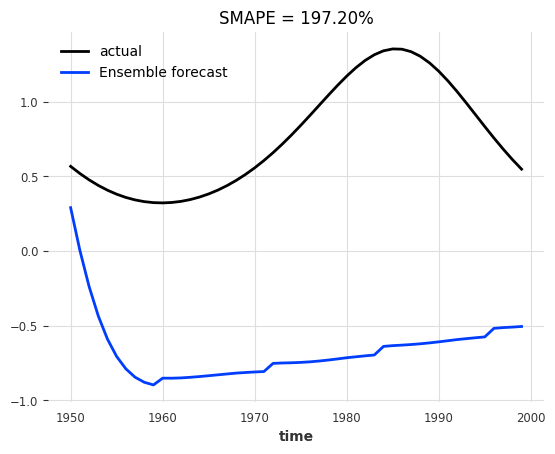

In [200]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### ARIMA & Croston

In [201]:
from darts.models import NaiveDrift,FFT,Croston

In [202]:
models_=[
        #StatsForecastAutoARIMA(),
        #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
        #NaiveDrift()
        Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
        ARIMA(p = 20, d=2, q=20,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [203]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
                                    #NaiveDrift(),
                                    Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
                                    #StatsForecastAutoARIMA(),
                                    ARIMA(p = 20, d=2, q=20,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


Ensemble of all 2 forecasters:


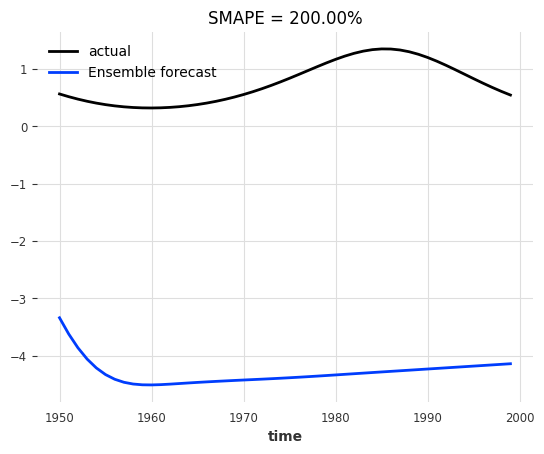

In [204]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### ARIMA & SF AutoTheta

In [209]:
from darts.models import NaiveDrift,FFT,Croston,StatsForecastAutoTheta

In [210]:
models_=[
        #StatsForecastAutoARIMA(),
        #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
        #NaiveDrift()
        StatsForecastAutoTheta(season_length=12),
        #Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
        ARIMA(p = 20, d=2, q=20,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [211]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
                                    StatsForecastAutoTheta(season_length=12),
                                    #NaiveDrift(),
                                    #Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
                                    #StatsForecastAutoARIMA(),
                                    ARIMA(p = 20, d=2, q=20,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


Ensemble of all 2 forecasters:


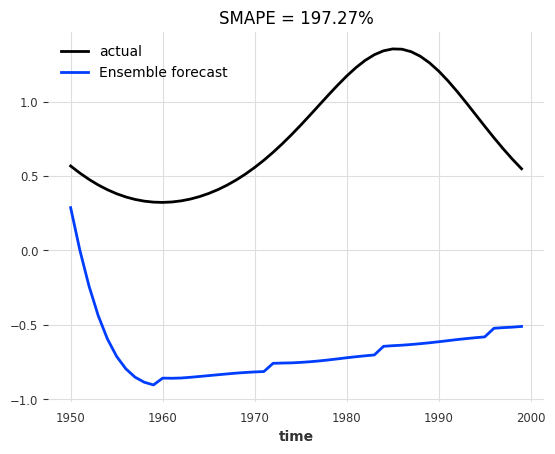

In [212]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### ARIMA & SF AutoETS

In [213]:
from darts.models import NaiveDrift,FFT,Croston,StatsForecastAutoETS

In [214]:
models_=[
        #StatsForecastAutoARIMA(),
        #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
        #NaiveDrift()
        StatsForecastAutoETS(season_length=4,model='AAZ'),
        #StatsForecastAutoTheta(),
        #Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
        ARIMA(p = 20, d=2, q=20,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [215]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
                                    StatsForecastAutoETS(season_length=4,model='AAZ'),
                                    #StatsForecastAutoTheta()
                                    #NaiveDrift(),
                                    #Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
                                    #StatsForecastAutoARIMA(),
                                    ARIMA(p = 20, d=2, q=20,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


Ensemble of all 2 forecasters:


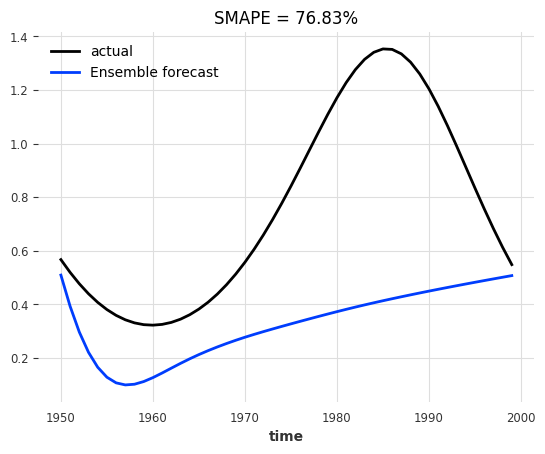

In [216]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### ARIMA &FourTheta

In [217]:
models_=[
        #StatsForecastAutoARIMA(),
        #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
        ARIMA(p = 20, d=2, q=20,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        FourTheta(theta=1,seasonality_period=None,season_mode=SeasonalityMode.ADDITIVE,model_mode=ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL,normalization=False)
]

In [218]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
                                    #StatsForecastAutoARIMA(),
                                    ARIMA(p = 20, d=2, q=20,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    FourTheta(theta=1,seasonality_period=None,season_mode=SeasonalityMode.ADDITIVE,model_mode=ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL,normalization=False)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


Ensemble of all 2 forecasters:


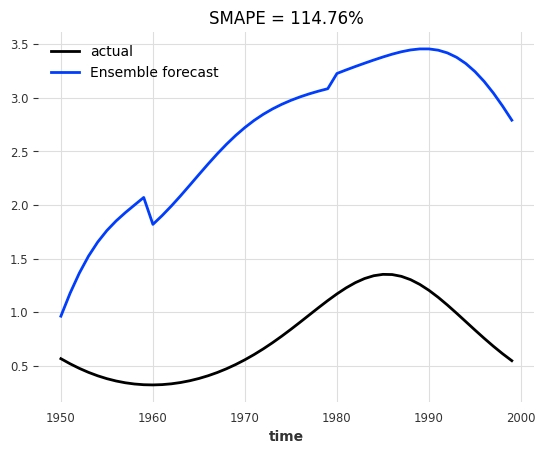

In [219]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### SF AutoARIMA & NaiveDrift

In [220]:
from darts.models import NaiveDrift,FFT

In [221]:
models_=[
        StatsForecastAutoARIMA(),
        #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
        NaiveDrift(),
        #ARIMA(p = 3, d= 0, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [222]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
                                    NaiveDrift(),
                                    StatsForecastAutoARIMA(),
                                    #ARIMA(p = 3, d= 0, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


Ensemble of all 2 forecasters:


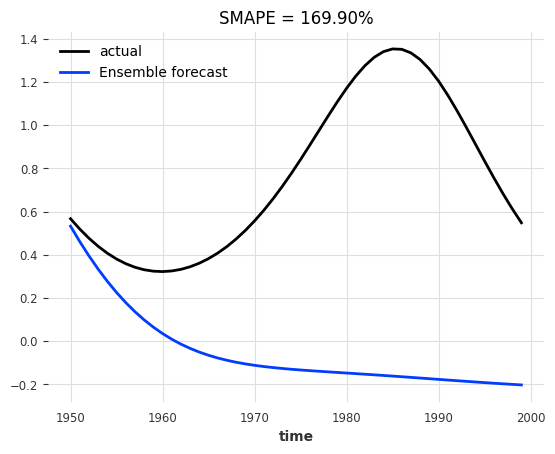

In [223]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### SF AutoARIMA & Expon

In [224]:
from darts.models import NaiveDrift,FFT

In [225]:
models_=[
        StatsForecastAutoARIMA(),
        #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
        #NaiveDrift()
        #ARIMA(p = 3, d= 0, q=5,random_state=0),
        ExponentialSmoothing(trend=None, damped=False, seasonal=SeasonalityMode.ADDITIVE, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [226]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
                                    #NaiveDrift()
                                    StatsForecastAutoARIMA(),
                                    #ARIMA(p = 3, d=0, q=5,random_state=0),
                                    ExponentialSmoothing(trend=None, damped=False, seasonal=SeasonalityMode.ADDITIVE, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


Ensemble of all 2 forecasters:


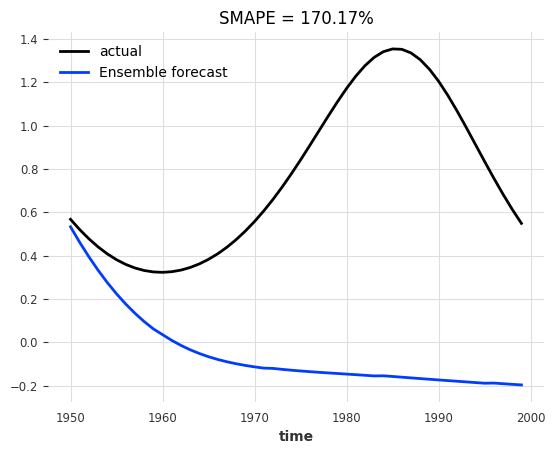

In [227]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### SF AutoARIMA & Croston

In [228]:
from darts.models import NaiveDrift,FFT,Croston

In [229]:
models_=[
        StatsForecastAutoARIMA(),
        #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
        #NaiveDrift()
        Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
        #ARIMA(p = 3, d=0, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [230]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
                                    #NaiveDrift(),
                                    Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
                                    StatsForecastAutoARIMA(),
                                    #ARIMA(p = 3, d=0, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


Ensemble of all 2 forecasters:


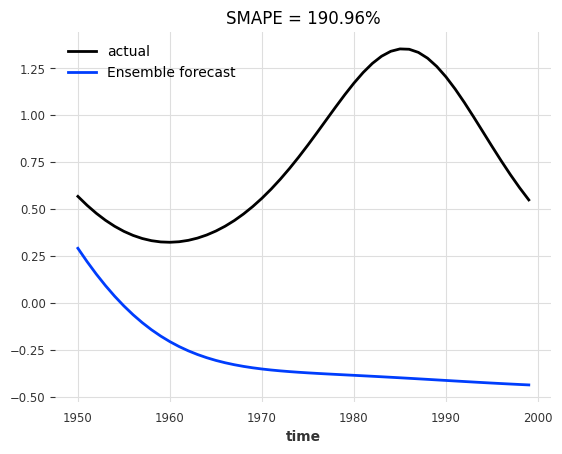

In [231]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### SF AutoARIMA & SF AutoTheta

In [232]:
from darts.models import NaiveDrift,FFT,Croston,StatsForecastAutoTheta

In [233]:
models_=[
        StatsForecastAutoARIMA(),
        #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
        #NaiveDrift()
        StatsForecastAutoTheta(season_length=12),
        #Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
        #ARIMA(p = 3, d=0, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [234]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
                                    StatsForecastAutoTheta(season_length=12),
                                    #NaiveDrift(),
                                    #Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
                                    StatsForecastAutoARIMA(),
                                    #ARIMA(p = 3, d=0, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


Ensemble of all 2 forecasters:


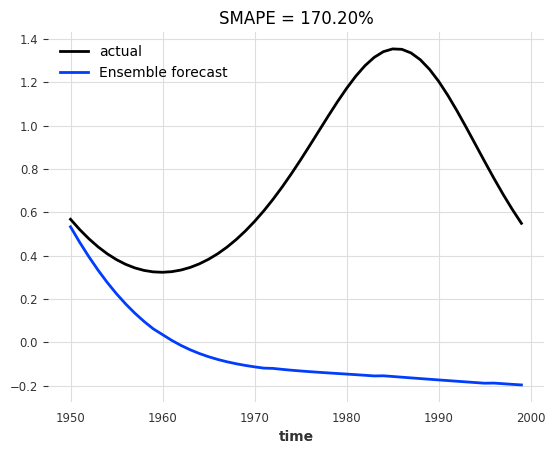

In [235]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### SF AutoARIMA & SF AutoETS

In [236]:
from darts.models import NaiveDrift,FFT,Croston,StatsForecastAutoETS

In [237]:
models_=[
        StatsForecastAutoARIMA(),
        #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
        #NaiveDrift()
        StatsForecastAutoETS(season_length=4,model='AAZ'),
        #StatsForecastAutoTheta(),
        #Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
        #ARIMA(p = 3, d= 0, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [238]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #Prophet(),
                                    #FFT(nr_freqs_to_keep=0,trend='poly',trend_poly_degree=0),
                                    StatsForecastAutoETS(season_length=4,model='AAZ'),
                                    #StatsForecastAutoTheta()
                                    #NaiveDrift(),
                                    #Croston(version='tsb',alpha_d=0.01,alpha_p=0.0),
                                    StatsForecastAutoARIMA(),
                                    #ARIMA(p = 3, d= 0, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    #RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    #NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=1,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


Ensemble of all 2 forecasters:


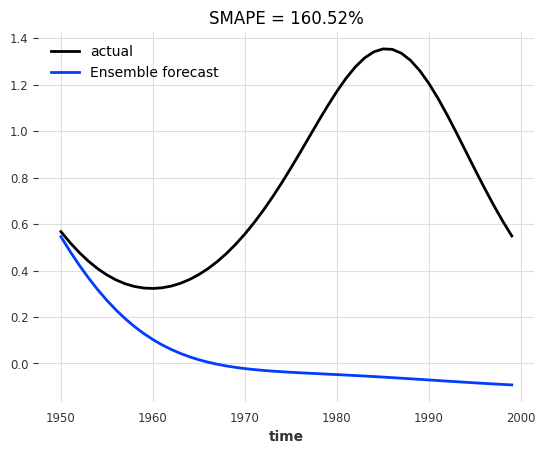

In [239]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models_

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### SF AutoARIMA & FourTheta

In [240]:
from darts.models import StatsForecastAutoARIMA
models=[
        StatsForecastAutoARIMA(),
        FourTheta(theta=1,seasonality_period=None,season_mode=SeasonalityMode.ADDITIVE,model_mode=ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL,normalization=False),

        ]

In [241]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    StatsForecastAutoARIMA(),
                                    FourTheta(theta=1,seasonality_period=None,season_mode=SeasonalityMode.ADDITIVE,model_mode=ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL,normalization=False),


                                    ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


Ensemble of all 2 forecasters:


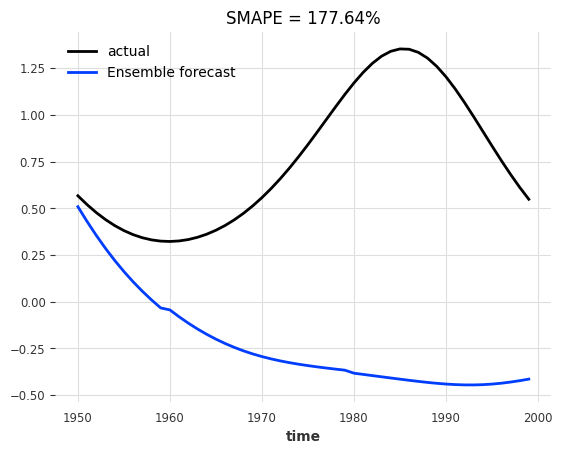

In [242]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = [#"SFAutoARIMA",
             "4Theta",'AutoARIMA' "avg", "Ensemble"]
models2 = models

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)


#### Ensemble RF dan NBEATS

In [243]:
models=[
        #ARIMA(p = 3, d= 1, q=5,random_state=0),
        #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
        RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
        NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
        FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
]

In [244]:
# ensemble forecast evaluation function:
# the eval function calls the methods contained in the list 'models'

def ensemble_eval(train, test, models):
    #t_start =  time.perf_counter()
    n_train = 12                # use 50 observation to train the ensemble model
    n_val = len(test)            # forecast as many periods as are in the valuation dataset


    # compute predictions
    # ensemble_model = RegressionEnsembleModel(forecasting_models=models, regression_train_n_points=n_train)
    # new Jan 022: RegressionEnsembleModel class no longer accepts as argument the list "models" of previously instantiated models
    # instead, explicitly list each of the forecast methods
    ensemble_model = RegressionEnsembleModel(
                                forecasting_models=[
                                    #ARIMA(p = 3, d= 1, q=5,random_state=0),
                                    #ExponentialSmoothing(trend=None, damped=False, seasonal=None, random_state=0),
                                    RandomForest(lags= 12, output_chunk_length= 25, n_estimators= 50, random_state= 0),
                                    NBEATSModel(input_chunk_length=5,output_chunk_length=5,random_state=0),
                                    #FourTheta(theta=0,seasonality_period = None, season_mode = SeasonalityMode.ADDITIVE, model_mode = ModelMode.ADDITIVE,trend_mode=TrendMode.EXPONENTIAL, normalization=True)
                                                        ],
                                regression_train_n_points=12,
                                #regression_model = RandomForest(lags=None,lags_future_covariates = [0], lags_past_covariates = None, output_chunk_length=12 ,add_encoders=None, n_estimators= 50, random_state= 0 )
                                )


    ensemble_model.fit(train)
    forecast = ensemble_model.predict(n_val)
    resid = forecast - test


    res_accuracy = accuracy_metrics(test, forecast, resid)#,t_start


    # plot the ensemble forecast
    #data.plot(label="actual") #kalau mau liat seluruh data
    test.plot(label="actual") # kalau mau liat perbandingan data test dgn forecast
    forecast.plot(label="Ensemble forecast")
    plt.title("SMAPE = {:.2f}%".format(res_accuracy["SMAPE"]))
    plt.legend();


    results = [forecast, res_accuracy]
    return results


Ensemble of all 2 forecasters:


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.0 M 
---------------------------------------------------
6.0 M     Trainable params
1.3 K     Non-trainable params
6.0 M     Total params
24.185    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollec

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


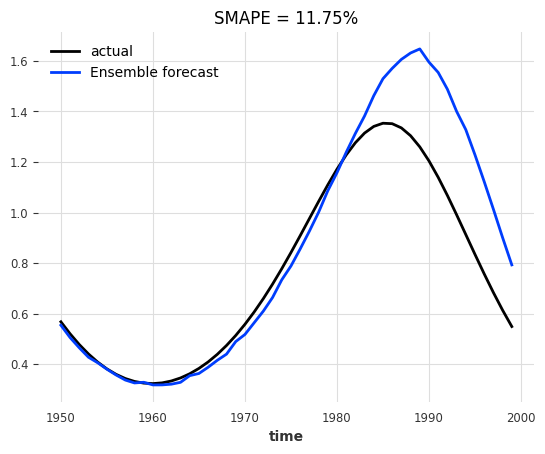

In [245]:
# call the ensemble eval function with all 5 forecasters:

# column headers and model selection:
col_heads = ["ARIMA",  "Exponential Smoothing", "avg", "Ensemble"]
models2 = models

# run the ensemble forecast
print("Ensemble of all 2 forecasters:")
res_ensemble = ensemble_eval(train,test, models2)
